In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
pd.options.mode.chained_assignment = None
from scipy.stats import zscore

from aicspylibczi import CziFile
from PIL import Image, ImageEnhance

from Bio.Seq import Seq
from Bio import SeqIO
wd = '/Users/wuhao/Data/Yeast/1_RawData/'
fwd = '/Users/wuhao/Data/Yeast/5_Figure_Antisense/'

import csv
from plotArgs import *

import gc
from functools import lru_cache
import matplotlib.colors as mcolors

# Functions

In [2]:
# df = pd.read_excel('3_Table/Summary_RNA_Gini_MS.xlsx')
# df = df[['GENE_ID', 'GENE_name']]
# df.columns = ['ID', 'symbol']
# df.to_csv('3_Table/Gene_ID_symbol.csv', index = False)
def id2symbol(i):
    df = pd.read_csv('3_Table/Gene_ID_symbol.csv')
    return df.loc[df['ID'] == i, 'symbol'].values[0] if i in df['ID'].to_list() else np.nan
def symbol2id(i):
    df = pd.read_csv('3_Table/Gene_ID_symbol.csv')
    return df.loc[df['symbol'] == i, 'ID'].values[0] if i in df['symbol'].to_list() else np.nan

def read_fasta(fasta_path):
    if not os.path.exists(fasta_path):
        print(f"file not exists")
        return None
    
    genome_records = {}
    for record in SeqIO.parse(fasta_path, "fasta"):
        genome_records[record.id] = str(record.seq)
    return genome_records

def read_gff(gff_path):
    if not os.path.exists(gff_path):
        print(f"file not exists")
        return None
    
    annotations = []
    with open(gff_path, "r") as file:
        for line in file:
            if line.startswith("#"):  # Skip comment lines
                continue
            fields = line.strip().split("\t")
            if len(fields) == 9:  # Ensure valid GFF line
                annotation = {
                    "seqid": fields[0],      
                    "source": fields[1],     
                    "type": fields[2],       
                    "start": int(fields[3]), 
                    "end": int(fields[4]),   
                    "score": fields[5],      
                    "strand": fields[6],     
                    "phase": fields[7],      
                    "attributes": fields[8]  
                }
                annotations.append(annotation)
    return annotations

def p_to_significance(p):
    if p <= 0.0001:
        return '****'
    elif p <= 0.001:
        return '***'
    elif p <= 0.01:
        return '**'
    elif p <= 0.05:
        return '*'
    else:
        return ''
    
def plot_sig(xstart,xend, yend,sig):
    plt.hlines(yend, xstart, xend, color="black", linewidth = 0.5)
    if sig == "NS":
        plt.annotate(r'%s'%sig, xy=((xstart + xend)/2, yend+0.05), 
            color="black", ha='center', fontstyle='italic')
    else:
        plt.annotate(r'%s'%sig, xy=((xstart + xend)/2, yend+0.01), color="black", ha='center')

# Main figures

## Fig. 1a pairwise cor and gene examples (HAC1, GAS5)

calculate r value between pariwise stages\
stroe at ./3_Table_Antisense/Corr_2stages.xlsx

In [3]:
# output wig file, only A,C, depth cutoff=350
# for tps in ['YPD', '0h', '6h',  '7h', '7h25', '7h50', '8h25', '8h75', '9h5']:
#     df1 = pd.read_table('3_Table/shapemapper_'+tps+'Normalized.txt')
#     df1 = df1[(df1.depth > 350) & (df1.Sequence.isin(['A', 'C']))][['Nucleotide', 'Norm_profile']].dropna()
#     with open('./3_Table_Antisense/Wig/'+ tps+ '.wig', 'w') as f1:
#         f1.write('variableStep chrom=sk1_transcriptome\n')
#         for index, row in df1.iterrows():
#             f1.write(f"{int(row['Nucleotide'])} {row['Norm_profile']}\n")

In [ ]:
# # calculate delta Reactivity and r value
# df = pd.read_excel('./3_Table_Antisense/Supplementary Tables.xlsx', 
#     sheet_name = 'Table S2', index_col= 'Gene_ID')
# dfsite = pd.read_csv('3_Table/Assigned_metagene_seq.csv')
# tps = ['YPD', '0h', '6h',  '7h', '7h25', '7h50', '8h25', '8h75', '9h5']
# def DMS_corr(t1, t2, depth = 350):
#     df1 = pd.read_table('3_Table/shapemapper_'+t1+'Normalized.txt')
#     df2 = pd.read_table('3_Table/shapemapper_'+t2+'Normalized.txt')
#     df2 = df2.drop(['Nucleotide', 'Sequence'], axis = 1)
#     df3 = pd.merge(df1, df2, left_index=True, right_index=True)
#     df3['depth'] = df3[['depth_x', 'depth_y']].min(axis = 1)
#     df3 = pd.merge(df3, dfsite[['Nucleotide', 'Gene', 'Pos',  'site_from_start_codon', 'site_from_end_codon']], on='Nucleotide')
#     df3 = df3[df3.Sequence.isin(['A', 'C']) & (df3.depth >= depth)][['Gene', 'Norm_profile_x', 'Norm_profile_y']]
#     df3 = df3.dropna()
#     df3['deltaReac'] = df3['Norm_profile_x'] - df3['Norm_profile_y']
#     dfcorr = df3.groupby(['Gene'])[['Norm_profile_x', 'Norm_profile_y']].corr().reset_index().drop_duplicates(subset=['Gene'])
#     dfcorr = dfcorr.set_index('Gene')[['Norm_profile_y']]
#     dfcorr.columns = ['corr']
#     dfcorr['len'] = df3.groupby(['Gene']).size()
#     dfcorr['MedianDeltaReac'] = df3.groupby(['Gene'])['deltaReac'].median()
#     dfcorr = dfcorr[dfcorr.len >= 200]
#     dfcorr['Gene_ID'] = dfcorr.index
#     dfcorr['Stage1'] = t1
#     dfcorr['Stage2'] = t2
#     dfcorr = dfcorr.reset_index(drop=True)
#     return dfcorr

# dfcorr = pd.DataFrame()
# for i in range(0, len(tps)-1):
#     for j in range(i+1, len(tps)):
#         t1 = tps[i]
#         t2 = tps[j]
#         dfcorr = pd.concat([dfcorr, DMS_corr(t1, t2)]) 
# dfcorr = dfcorr.reset_index(drop=True)
# dfcorr['Gene_symbol'] = dfcorr.apply(lambda x: df.loc[x['Gene_ID'], 'Gene_symbol'] \
#     if x['Gene_ID'] in df.index.to_list() else np.nan, axis = 1)
# dfcorr.to_excel('./3_Table_Antisense/Corr_2stages.xlsx')

# dftps = pd.DataFrame(columns=['tps', 'timepoint'])
# tps = ['V', 'P', 'T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6']
# dftps['tps'] = tps
# dftps['timepoint'] = ['YPD', '0h', '6h',  '7h', '7h25', '7h50', '8h25', '8h75', '9h5']
# dfcorr['Stage1'] = dfcorr['Stage1'].map(dftps.set_index('timepoint')['tps'])
# dfcorr['Stage2'] = dfcorr['Stage2'].map(dftps.set_index('timepoint')['tps'])
# dfcorr.to_excel('./3_Table_Antisense/Corr_2stages.xlsx')

statistics of pairwise number, gene number

In [ ]:
dfcorr = pd.read_excel('./3_Table_Antisense/Corr_2stages.xlsx', index_col=0)
print('times of pairwise correlation analysis:', dfcorr.shape[0]) 
print('genes involved in pairwise correlation analysis:', len(dfcorr['Gene_ID'].unique()))

# Calculate the stages (Stage1 and Stage2) contained in each gene
dfn = pd.DataFrame({
    'Stage1': dfcorr.groupby('Gene_ID')['Stage1'].unique(),
    'Stage2': dfcorr.groupby('Gene_ID')['Stage2'].unique()
})
# Merge the lists of Stage1 and Stage2
dfn['Stage'] = dfn.apply(lambda x: set(('_'.join(x['Stage1'])+'_'+ '_'.join(x['Stage2'])).split('_')), axis = 1)
dfn['StageNumb'] = dfn['Stage'].apply(len)
print(dfn.groupby('StageNumb').size())

times of pairwise correlation analysis: 28601
genes involved in pairwise correlation analysis: 2061
StageNumb
2    293
3    306
4    268
5    190
6    336
7    220
8    206
9    242
dtype: int64


heatmap of r value (HAC1 GAS5)

In [ ]:
def heatmap_qvalue(gene):
    tps = ['V', 'P', 'T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6']
    dfplot = pd.DataFrame(0.0, index=tps, columns=tps)
    dfg = dfcorr[dfcorr.Gene_symbol == gene].pivot(index='Stage1', columns='Stage2', values='corr')
    # Fill dfg values into dfplot
    dfplot.update(dfg)
    dfplot.fillna(0, inplace=True)
    sns.heatmap(dfplot, cmap = 'Purples_r', vmin=0.25, 
        vmax = 1, mask=(dfplot == 0))
    plt.title(gene)
    # plt.show()

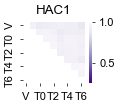

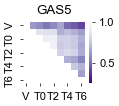

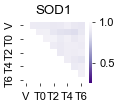

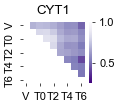

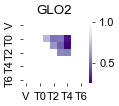

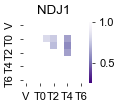

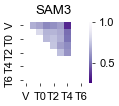

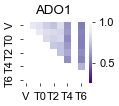

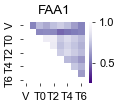

In [ ]:
# heatmap_qvalue('HAC1')
# heatmap_qvalue('GAS5')
# heatmap_qvalue('SOD1')
# heatmap_qvalue('CYT1')
# heatmap_qvalue('GLO2')
# heatmap_qvalue('NDJ1')
# heatmap_qvalue('SAM3')
# heatmap_qvalue('ADO1')
# heatmap_qvalue('FAA1')

## Fig. 1b distribution of pairwise correlation coefficients


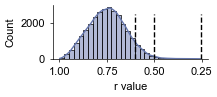

In [ ]:
dfcorr = pd.read_excel('./3_Table_Antisense/Corr_2stages.xlsx', index_col=0)
plt.figure(figsize=(2, 0.7))
sns.histplot(dfcorr['corr'], bins=30, kde=True,linewidth = 0.5, 
    edgecolor = 'k', color = '#6475AC', alpha = 0.5)
plt.xlabel('r value')
plt.ylabel('Count')
plt.gca().invert_xaxis()
plt.vlines(0.255563431969592, 0, 2500, color = 'k', linestyle = '--', linewidth = 1)
plt.vlines(0.5, 0, 2500, color = 'k', linestyle = '--', linewidth = 1)
plt.vlines(0.6, 0, 2500, color = 'k', linestyle = '--', linewidth = 1)
# plt.savefig('./5_Figure_Antisense/Fig1b_corr_bin_v2.pdf',  bbox_inches = 'tight')
# plt.show()

In [268]:
dfcorr.sort_values('corr').head(1)

,corr,len,MedianDeltaReac,Gene_ID,Stage1,Stage2,Gene_symbol,deltaGini,absdeltaGini,absMedianDeltaReac
8,0.255563,256,0.239925,YDR272W,T1,T4,GLO2,-0.159791,0.159791,0.239925


## Fig. 1c GLO2 DMS reactivity

In [2]:
dfsite = pd.read_csv('3_Table/Assigned_metagene_seq.csv')
class DMSDataManager:
    """
    Efficient DMS Data Manager (Fixed Version)
    Features:
    1. Lazy Loading - Load data only when needed
    2. LRU Cache - Smart memory management, avoid repeated loading
    3. Batch Processing - Support multi-timepoint analysis
    4. Memory Optimization - Automatic cleanup of unnecessary data
    """
    
    def __init__(self, data_path='3_Table/', timepoints=None, depth_cutoff=50):
        self.data_path = data_path
        self.timepoints = timepoints or ['YPD', '0h', '6h', '7h', '7h25', '7h50', '8h25', '8h75', '9h5']
        self.depth_cutoff = depth_cutoff
        self.cache = {}
        self.dfsite = dfsite  # Use pre-loaded dfsite
        
        print(f"DMS Data Manager Initialized")
        print(f"Timepoints: {self.timepoints}")
        print(f"Depth threshold: {depth_cutoff}")
        
        # Check available DMS reactivity columns
        self.reactivity_columns = ['Reactivity_profile', 'HQ_profile', 'Norm_profile']
        print(f"Available reactivity columns: {self.reactivity_columns}")
    
    @lru_cache(maxsize=3)  # Cache at most 3 timepoint raw data
    def _load_raw_data(self, timepoint):
        """Lazy load raw DMS data"""
        filepath = f'{self.data_path}shapemapper_{timepoint}Normalized.txt'
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"Data file not found: {filepath}")
        
        print(f"Loading {timepoint} data...")
        df = pd.read_table(filepath)
        print(f"{timepoint} data loaded: {len(df):,} rows")
        return df
    
    def get_dms_data(self, timepoint, genes=None, nucleotides=['A', 'C'], 
                    depth_cutoff=None, cache_key=None, reactivity_col='Norm_profile'):
        """
        Get DMS data for specific timepoint
        
        Parameters:
        - timepoint: timepoint
        - genes: gene list, None for all genes
        - nucleotides: nucleotide types, default ['A', 'C']
        - depth_cutoff: depth threshold, None uses default
        - cache_key: cache key for storing processed data
        - reactivity_col: reactivity column to use
        """
        depth_cutoff = depth_cutoff or self.depth_cutoff
        
        # Generate cache key
        if cache_key is None:
            gene_str = 'all' if genes is None else f'{len(genes)}genes'
            cache_key = f"{timepoint}_{gene_str}_{'-'.join(nucleotides)}_d{depth_cutoff}_{reactivity_col}"
        
        # Check cache
        if cache_key in self.cache:
            print(f"Retrieved from cache: {cache_key}")
            return self.cache[cache_key]
        
        # Load and process data
        raw_data = self._load_raw_data(timepoint)
        
        # Merge with site information
        merged_data = pd.merge(
            raw_data, 
            self.dfsite[['Nucleotide', 'Gene', 'Pos', 'site_from_start_codon', 'site_from_end_codon']], 
            on='Nucleotide'
        )
        
        # Apply filtering conditions
        filtered_data = merged_data[
            (merged_data.Sequence.isin(nucleotides)) & 
            (merged_data.depth >= depth_cutoff) &
            (merged_data[reactivity_col].notna())  # Ensure reactivity data is not null
        ]
        
        # Gene filtering
        if genes is not None:
            if isinstance(genes, str):
                genes = [genes]  # Convert to list
            filtered_data = filtered_data[filtered_data.Gene.isin(genes)]
        
        # Add DMS_Reactivity column for compatibility
        filtered_data = filtered_data.copy()
        filtered_data['DMS_Reactivity'] = filtered_data[reactivity_col]
        
        # Cache results
        self.cache[cache_key] = filtered_data
        print(f"Data cached: {cache_key} ({len(filtered_data):,} rows)")

        return filtered_data
    
    def get_multiple_timepoints(self, timepoints, genes=None, **kwargs):
        """Batch retrieve data for multiple timepoints"""
        results = {}
        for tp in timepoints:
            results[tp] = self.get_dms_data(tp, genes=genes, **kwargs)
        return results
    
    def calculate_correlations(self, timepoint1, timepoint2, genes=None, min_positions=10):
        """Calculate DMS reactivity correlation coefficients between two timepoints"""
        print(f"🔄 Calculating correlations: {timepoint1} vs {timepoint2}")
        
        # Get data for both timepoints
        data1 = self.get_dms_data(timepoint1, genes=genes)
        data2 = self.get_dms_data(timepoint2, genes=genes)
        
        if data1.empty or data2.empty:
            print("Insufficient data for correlation analysis")
            return pd.DataFrame()
        
        # Merge data for correlation analysis
        merged = pd.merge(
            data1[['Gene', 'Pos', 'DMS_Reactivity']].rename(columns={'DMS_Reactivity': f'DMS_{timepoint1}'}),
            data2[['Gene', 'Pos', 'DMS_Reactivity']].rename(columns={'DMS_Reactivity': f'DMS_{timepoint2}'}),
            on=['Gene', 'Pos']
        )
        
        # Calculate correlation coefficients by gene
        correlations = []
        for gene in merged['Gene'].unique():
            gene_data = merged[merged['Gene'] == gene]
            if len(gene_data) >= min_positions:
                corr = gene_data[f'DMS_{timepoint1}'].corr(gene_data[f'DMS_{timepoint2}'])
                correlations.append({
                    'Gene': gene,
                    'r_value': corr,
                    'n_positions': len(gene_data),
                    'comparison': f'{timepoint1}_vs_{timepoint2}'
                })
        
        return pd.DataFrame(correlations)
    
    def get_data_summary(self, timepoint):
        """Get data summary statistics"""
        data = self.get_dms_data(timepoint)
        if data.empty:
            return f"{timepoint}: No data"
        
        summary = {
            'timepoint': timepoint,
            'total_positions': len(data),
            'unique_genes': data['Gene'].nunique(),
            'avg_depth': data['depth'].mean(),
            'reactivity_range': (data['DMS_Reactivity'].min(), data['DMS_Reactivity'].max())
        }
        return summary
    
    def clear_cache(self, pattern=None):
        """Clear cache"""
        if pattern is None:
            self.cache.clear()
            print("All cache cleared")
        else:
            keys_to_remove = [k for k in self.cache.keys() if pattern in k]
            for k in keys_to_remove:
                del self.cache[k]
            print(f"Cleared {len(keys_to_remove)} cache items matching '{pattern}'")
        
        # Force garbage collection
        gc.collect()
    
    def get_cache_info(self):
        """Get cache status information"""
        print("Cache Status:")
        print(f"   Number of cache items: {len(self.cache)}")
        for key, data in self.cache.items():
            size = len(data) if hasattr(data, '__len__') else 'unknown'
            print(f"   {key}: {size:,} rows")
        print(f"   Raw data cache: {self._load_raw_data.cache_info()}")

def clean_multi_data(multi_data_dict, min_reactivity=0):
    return {tp: df[df['DMS_Reactivity'] >= min_reactivity].copy() 
            for tp, df in multi_data_dict.items() if len(df) > 0}
# Re-initialize data manager (with lower depth threshold)
dms_manager = DMSDataManager(depth_cutoff=350)

DMS Data Manager Initialized
Timepoints: ['YPD', '0h', '6h', '7h', '7h25', '7h50', '8h25', '8h75', '9h5']
Depth threshold: 350
Available reactivity columns: ['Reactivity_profile', 'HQ_profile', 'Norm_profile']


In [3]:
tps = ['V', 'P', 'T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6']
timepoints = ['YPD', '0h', '6h',  '7h', '7h25', '7h50', '8h25', '8h75', '9h5']
# dms_manager = DMSDataManager(depth_cutoff=350)
# ypd_data = dms_manager.get_dms_data('YPD', depth_cutoff=350)

In [ ]:
gene = symbol2id('GLO2')
key_timepoints = ['7h','8h25']
multi_data = dms_manager.get_multiple_timepoints(
    timepoints=key_timepoints,
    genes=gene,
    depth_cutoff=350,
)
multi_data = clean_multi_data(multi_data, min_reactivity=0)

dfdelta = pd.merge(multi_data['7h'][['site_from_start_codon', 'DMS_Reactivity']],
        multi_data['8h25'][['site_from_start_codon', 'DMS_Reactivity']],
        on='site_from_start_codon',
        suffixes=('_7h', '_8h25'))

Loading 7h data...
7h data loaded: 11,838,912 rows
Data cached: 7h_7genes_A-C_d350_Norm_profile (415 rows)
Loading 8h25 data...
8h25 data loaded: 11,838,912 rows
Data cached: 8h25_7genes_A-C_d350_Norm_profile (257 rows)


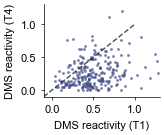

In [ ]:
plt.figure(figsize=(1.5, 1.2))
plt.scatter(dfdelta.DMS_Reactivity_7h, dfdelta.DMS_Reactivity_8h25, s = 1.5, alpha = 0.5, 
    color = '#414986')
plt.xlim(-0.1, 1.3)
plt.ylim(-0.1, 1.3)
plt.xlabel('DMS reactivity (T1)')
plt.ylabel('DMS reactivity (T4)')
plt.plot([-0.1, 1], [-0.1, 1], 'k--', linewidth=1, alpha=0.7)
# plt.savefig('./5_Figure_Antisense/Fig1c_GLO2_DMSreact_T1vsT4.pdf', bbox_inches = 'tight')
# plt.show()

## Fig. 1d delta median reactivity

In [337]:
dfplot = dfcorr.sort_values('MedianDeltaReac', ascending=False)
dfplot = dfplot.drop_duplicates(subset='Gene_ID')
top_genes = dfplot.head(5)

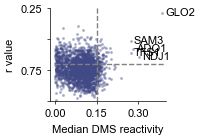

In [ ]:
# plt.figure(figsize=(1, 0.8))
plt.figure(figsize=(1.5, 1.2))
plt.scatter(dfplot['absMedianDeltaReac'], dfplot['corr'], 
        s = 1.5, alpha = 0.3, color = '#414986')
for _, row in top_genes.iterrows():
    plt.text(row['absMedianDeltaReac']+0.01, row['corr']+0.02, row['Gene_symbol'])
plt.xlabel('Median DMS reactivity')
plt.ylabel('r value')
plt.ylim(0.25, 0.7)
plt.xlim(-0.02, 0.4)
plt.xticks([0.0, 0.15, 0.3])
plt.yticks([0.25, 0.5, 0.75, 1], ['0.25','','0.75',''])
plt.gca().invert_yaxis()
plt.hlines(0.7, 0, 0.4, color = 'gray', linestyles='--')
plt.vlines(0.15, 0.25, 1, color = 'gray', linestyles='--')
# plt.savefig('./5_Figure_Antisense/Fig1d_dltDMSReact.pdf',  bbox_inches = 'tight')
# plt.show()

In [370]:
dfplot.head(5)

,corr,len,MedianDeltaReac,Gene_ID,Stage1,Stage2,Gene_symbol,deltaGini,absdeltaGini,absMedianDeltaReac
0,0.289464,223,0.386433,YDR272W,T0,T4,GLO2,-0.161149,0.161149,0.386433
1,0.641558,524,0.304305,YOL104C,T0,T4,NDJ1,-0.102861,0.102861,0.304305
2,0.575860,288,0.280198,YJR105W,T0,T4,ADO1,-0.197661,0.197661,0.280198
3,0.511703,267,0.274314,YPL274W,T0,T4,SAM3,-0.125100,0.125100,0.274314
4,0.612478,280,0.273907,YLR178C,T0,T4,TFS1,-0.067217,0.067217,0.273907


## Fig. 1e delta DMS reactivity

In [426]:
dms_manager = DMSDataManager(depth_cutoff=350)

DMS Data Manager Initialized
Timepoints: ['YPD', '0h', '6h', '7h', '7h25', '7h50', '8h25', '8h75', '9h5']
Depth threshold: 350
Available reactivity columns: ['Reactivity_profile', 'HQ_profile', 'Norm_profile']


In [434]:
# 'YDR272W', 'YOL104C', 'YJR105W', 'YPL274W', 'YLR178C'
# GLO2, NDJ1, ADO1, SAM3, TFS1
tps = ['V', 'P', 'T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6']
timepoints = ['YPD', '0h', '6h',  '7h', '7h25', '7h50', '8h25', '8h75', '9h5']
# dms_manager = DMSDataManager(depth_cutoff=350)
# ypd_data = dms_manager.get_dms_data('YPD', depth_cutoff=350)

gene = ['YDR272W', 'YOL104C', 'YJR105W', 'YPL274W', 'YLR178C']
key_timepoints = ['6h','8h25']
multi_data = dms_manager.get_multiple_timepoints(
    timepoints=key_timepoints,
    genes=gene,
    depth_cutoff=350,
)
multi_data = clean_multi_data(multi_data, min_reactivity=0)

dfdelta = pd.merge(multi_data['6h'][['Gene', 'site_from_start_codon', 'DMS_Reactivity']],
        multi_data['8h25'][['Gene', 'site_from_start_codon', 'DMS_Reactivity']],
        on=['Gene', 'site_from_start_codon'],
        suffixes=('_6h', '_8h25'))

dfdelta['deltaReactivity'] = dfdelta['DMS_Reactivity_6h'] -  dfdelta['DMS_Reactivity_8h25']
dfdelta.loc[dfdelta['deltaReactivity'] > 0, 'color'] = '#CC3366'
dfdelta.loc[dfdelta['deltaReactivity'] < 0, 'color'] = '#3399CC'

Retrieved from cache: 6h_5genes_A-C_d350_Norm_profile
Retrieved from cache: 8h25_5genes_A-C_d350_Norm_profile


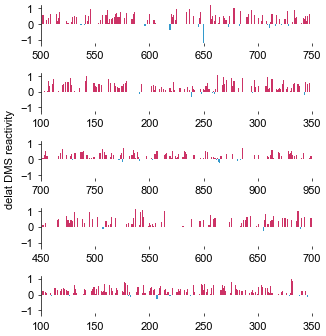

In [ ]:
# 'YDR272W', 'YOL104C', 'YJR105W', 'YPL274W', 'YLR178C' delta reactivity plot
# How to adjust each subplot to be smaller, with more space between subplots

dfplot = dfdelta[dfdelta.Gene == 'YDR272W']
fig, ax = plt.subplots(5, 1, figsize=[3.5, 4],sharex=False, sharey=True)
ax[0].bar(dfplot.site_from_start_codon, dfplot['deltaReactivity'], color=dfplot['color'], width=1.0, edgecolor='none', align='center')
ax[0].spines['top'].set_color('none')
ax[0].spines['left'].set_color('k')
ax[0].spines['bottom'].set_color('none')
ax[0].spines['right'].set_color('none')
ax[0].set_ylim(-1.2, 1.2)
ax[0].set_xlim(500, 750)

dfplot = dfdelta[dfdelta.Gene == 'YOL104C']
ax[1].bar(dfplot.site_from_start_codon, dfplot['deltaReactivity'], color=dfplot['color'], width=1.0, edgecolor='none', align='center')
ax[1].set_xlim(100, 350)
ax[1].spines['bottom'].set_color('none')

dfplot = dfdelta[dfdelta.Gene == 'YJR105W']
ax[2].bar(dfplot.site_from_start_codon, dfplot['deltaReactivity'], color=dfplot['color'], width=1.0, edgecolor='none', align='center')
ax[2].set_xlim(700, 950)
ax[2].spines['bottom'].set_color('none')
ax[2].set_ylabel('delat DMS reactivity')

dfplot = dfdelta[dfdelta.Gene == 'YPL274W']
ax[3].bar(dfplot.site_from_start_codon, dfplot['deltaReactivity'], color=dfplot['color'], width=1.0, edgecolor='none', align='center')
ax[3].set_xlim(450, 700)
ax[3].spines['bottom'].set_color('none')

dfplot = dfdelta[dfdelta.Gene == 'YLR178C']
ax[4].bar(dfplot.site_from_start_codon, dfplot['deltaReactivity'], color=dfplot['color'], width=1.0, edgecolor='none', align='center')
ax[4].set_xlim(100, 350)
ax[4].spines['bottom'].set_color('none')
plt.subplots_adjust(hspace=0.8) 
# plt.savefig('./5_Figure_Antisense/Fig_dltDMSReact_5genes_T0T4.pdf', bbox_inches = 'tight')
# plt.show()

## Fig. 1F dsRNA imaging

In [ ]:
# split channel from CZI files
# czi_path = "./5_Figure_Antisense/20220314 good confocol dsRNA along the timecourse/"
# czi_files = [i for i in os.listdir(czi_path) if i.endswith('.czi') and 'antisense' not in i]
# def split_czi(czi_path, czi_files):
#     for i in czi_files:
#         czi = CziFile(os.path.join(czi_path, i))
#         img, dims = czi.read_image()
#         channel_dims = dims[3][1]
#         for j in range(channel_dims):
#             img_ch = img[0, 0, 0, j, 0, :, :]
#             Image.fromarray(img_ch).save(os.path.join(czi_path, 'split/', i).replace('.czi', f'_ch{j}.tif'), mode='I;16')
# split_czi(czi_path, czi_files)

In [ ]:
## shell script to rename files to ASCII
# for f in *; do
#   new=$(echo "$f" | iconv -c -t ASCII//TRANSLIT)
#   [ "$f" != "$new" ] && mv "$f" "$new"
# done

In [ ]:
def Green2Red(file):
    img = Image.open(file)
    img_np = np.array(img)
    white_mask = np.all(img_np >= 100, axis=-1)
    mask = ~white_mask
    img_np[mask, 0] = img_np[mask, 1]   
    img_np[mask, 1] = 0                 
    Image.fromarray(img_np).save(file.replace('.tif', '_red.tif'))
files = [czi_path + 'Crop/' + i for i in os.listdir(czi_path+'Crop/') if i.endswith('c1+2.tif') and i.startswith('Cropped')]
for i in files:
    Green2Red(i)

## Fig. S1a distribution of median reactivity

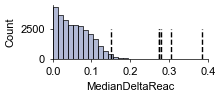

In [ ]:
dfcorr = pd.read_excel('./3_Table_Antisense/Corr_2stages.xlsx', index_col=0)
plt.figure(figsize=(2, 0.7))
sns.histplot(dfcorr['absMedianDeltaReac'], bins=30, linewidth = 0.5, 
    edgecolor = 'k', color = '#6475AC', alpha = 0.5)
plt.xlabel('MedianDeltaReac')
plt.ylabel('Count')
plt.xlim(0, 0.4)
plt.vlines(0.15, 0, 2500, color = 'k', linestyle = '--', linewidth = 1)
plt.vlines(0.273907, 0, 2500, color = 'k', linestyle = '--', linewidth = 1)
plt.vlines(0.274314, 0, 2500, color = 'k', linestyle = '--', linewidth = 1)
plt.vlines(0.280198, 0, 2500, color = 'k', linestyle = '--', linewidth = 1)
plt.vlines(0.304305, 0, 2500, color = 'k', linestyle = '--', linewidth = 1)
plt.vlines(0.386433, 0, 2500, color = 'k', linestyle = '--', linewidth = 1)
# plt.savefig('./5_Figure_Antisense/FigS1a_distributionofMediandeltaReac.pdf',  bbox_inches = 'tight')
# plt.show()

In [ ]:
dfplot = dfcorr.groupby('Gene_ID')['absMedianDeltaReac'].max().reset_index()


## Fig. S1b reactivity changes along meiosis

In [ ]:
# 'YDR272W', 'YOL104C', 'YJR105W', 'YPL274W', 'YLR178C'
# GLO2, NDJ1, ADO1, SAM3, TFS1
tps = ['V', 'P', 'T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6']
timepoints = ['YPD', '0h', '6h',  '7h', '7h25', '7h50', '8h25', '8h75', '9h5']
# dms_manager = DMSDataManager(depth_cutoff=350)
# ypd_data = dms_manager.get_dms_data('YPD', depth_cutoff=350)

gene = ['YDR272W', 'YOL104C', 'YJR105W', 'YPL274W', 'YLR178C']
multi_data = dms_manager.get_multiple_timepoints(
    timepoints=timepoints,
    genes=gene,
    depth_cutoff=350,
)
multi_data = clean_multi_data(multi_data, min_reactivity=0)

Loading YPD data...
YPD data loaded: 11,838,912 rows
Data cached: YPD_5genes_A-C_d350_Norm_profile (1,422 rows)
Loading 0h data...
0h data loaded: 11,838,912 rows
Data cached: 0h_5genes_A-C_d350_Norm_profile (1,548 rows)
Retrieved from cache: 6h_5genes_A-C_d350_Norm_profile
Loading 7h data...
7h data loaded: 11,838,912 rows
Data cached: 7h_5genes_A-C_d350_Norm_profile (2,285 rows)
Loading 7h25 data...
7h25 data loaded: 11,838,912 rows
Data cached: 7h25_5genes_A-C_d350_Norm_profile (2,511 rows)
Loading 7h50 data...
7h50 data loaded: 11,838,912 rows
Data cached: 7h50_5genes_A-C_d350_Norm_profile (1,105 rows)
Retrieved from cache: 8h25_5genes_A-C_d350_Norm_profile
Loading 8h75 data...
8h75 data loaded: 11,838,912 rows
Data cached: 8h75_5genes_A-C_d350_Norm_profile (645 rows)
Loading 9h5 data...
9h5 data loaded: 11,838,912 rows
Data cached: 9h5_5genes_A-C_d350_Norm_profile (578 rows)


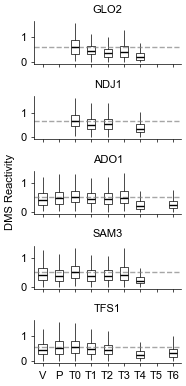

In [ ]:
# Plot boxplot for DMS reactivity of each gene at different timepoints
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'k', 'linewidth':0.5},
    'medianprops':{'color':'k', 'linewidth':1},
    'whiskerprops':{'color':'k', 'linewidth': 0.5},
    'capprops':{'color':'k', 'linewidth' :0}
}

# Only keep data with >=200 nucleotides for each gene at each timepoint
plot_data = []
for tp, df in multi_data.items():
    for g in gene:
        sub = df[df['Gene'] == g]
        if len(sub) >= 200:
            tmp = sub[['DMS_Reactivity']].copy()
            tmp['timepoint'] = tp
            tmp['gene'] = g
            plot_data.append(tmp)
plot_df = pd.concat(plot_data, ignore_index=True)

# Group plot, one row per gene
n_gene = len(gene)
fig, axes = plt.subplots(n_gene, 1, figsize=(2, 0.8*n_gene), sharex=True)

for i, g in enumerate(gene):
    ax = axes[i] if n_gene > 1 else axes
    sns.boxplot(
        data=plot_df[plot_df['gene'] == g],
        x='timepoint', y='DMS_Reactivity',
        showfliers=False, linewidth=0.5, ax=ax,
        order=timepoints,
        **PROPS, width=0.5
    )
    symbol = id2symbol(g)
    ax.set_title(symbol, fontsize=8)
    t0_median = plot_df[(plot_df['gene'] == g) & (plot_df['timepoint'] == '6h')]['DMS_Reactivity'].median()
    ax.axhline(t0_median, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    if i == 2:
        ax.set_ylabel('DMS Reactivity')
    else:
        ax.set_ylabel('')

    ax.set_xlabel('')

tps = ['V', 'P', 'T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6']
axes[-1].set_xticks(range(len(tps)))
axes[-1].set_xticklabels(tps)
plt.tight_layout()
# plt.savefig('./5_Figure_Antisense/FigS1b_boxplotDMSReac_5genes_alltimepoints.pdf', bbox_inches='tight')
# plt.show()

In [874]:
for i in gene:
    n1 = plot_df[(plot_df['gene'] == i) & (plot_df['timepoint'] == '6h')]['DMS_Reactivity']
    n2 = plot_df[(plot_df['gene'] == i) & (plot_df['timepoint'] == '7h')]['DMS_Reactivity']
    print(stats.mannwhitneyu(n1, n2))

MannwhitneyuResult(statistic=np.float64(83565.5), pvalue=np.float64(2.2811337606420583e-08))
MannwhitneyuResult(statistic=np.float64(210155.0), pvalue=np.float64(2.627122842091115e-12))
MannwhitneyuResult(statistic=np.float64(133087.0), pvalue=np.float64(0.00013543996492667592))
MannwhitneyuResult(statistic=np.float64(234388.5), pvalue=np.float64(2.26446965271893e-16))
MannwhitneyuResult(statistic=np.float64(60298.5), pvalue=np.float64(0.04266108485896829))


## Fig 2a clustering of antisense ratio

In [9]:
df = pd.read_excel('./3_Table_Antisense/Supplementary Tables.xlsx', 
sheet_name = 'Table S2', index_col= 'Gene_ID')

tps = ['YPD', '0h', '6h', '7h', '7h25', '7h5', '8h25', '8h75', '9h5']
dfRNA = pd.read_csv('./3_Table_Antisense/TPM_sense.csv', index_col='Geneid')
dfanti = pd.read_csv('./3_Table_Antisense/TPM_anti.csv', index_col='Geneid')
dfboth = pd.read_csv('./3_Table_Antisense/TPM_both.csv', index_col='Geneid')
dfRNA=dfRNA[tps]
dfanti=dfanti[tps]
dfboth=dfboth[tps]
# RNAseq cutoff = 10 TPM
dfboth = dfboth[dfboth>=10]
dfatr = dfanti/dfboth
dfatr[dfatr == 0] = np.nan
# data[data == 0] = np.nan
dfatr['dltAntiRatio'] = dfatr.max(axis=1) - dfatr.min(axis=1)

dfatr['Gene_symbol'] = dfatr.apply(lambda x: df.loc[x.name, 'Gene_symbol'] \
    if x.name in df.index.to_list() else np.nan, axis = 1)
dfatr = dfatr.sort_values('dltAntiRatio', ascending=False)
data = dfatr.loc[(dfatr['dltAntiRatio']>=0.2), tps]
data = data[data.isna().sum(axis = 1)<=1]
print(data.shape)
# data.to_csv('./3_Table_Antisense/heatmap/dltAntiRatioover0.2_7.5.table', sep = '\t')

(404, 9)


(0.0, 4000.0)

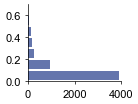

In [10]:
# choose genes with antisense ratio changes >= 20%
plotdata = dfatr.loc[dfatr['dltAntiRatio']>0, 'dltAntiRatio'].dropna()
plt.figure(figsize=(1.2, 1))
g1 = plt.hist(plotdata, bins = [i/10 for i in range(0,10)],
    linewidth = 0, edgecolor = 'k', color = '#6475AC', alpha =1,
    orientation='horizontal',rwidth= 0.8)
# plt.xlim(0, 500)
plt.ylim(0,0.7)
plt.yticks([0, 0.2, 0.4, 0.6])
plt.xlim(0,4000)
# plt.show()

## Fig. 2b and S2a examples of antisense ratio change (PUS9 USB1 NDJ1 SAM3 IME4)

0.48021113225908796 0.24480802655447303


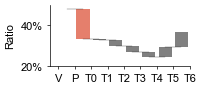

In [23]:
timepoints = ['YPD', '0h', '6h', '7h', '7h25', '7h5', '8h25', '8h75', '9h5']
col = ['V-P', 'P-T0', 'T0-T1', 'T1-T2', 'T2-T3', 'T3-T4','T4-T5', 'T5-T6']
# adjacent tps diff 
data1 = data[timepoints[:-1]]
data2 = data[timepoints[1:]]
data1.columns = col
data2.columns = col
data3 = data2-data1
# cls2 = pd.read_table('./3_Table_Antisense/heatmap/dltAntiRatioover0.2_7.5_increase.cdt')
# data3 = data3[data3.index.isin(cls2.Geneid)]
# max difference
data3['stage'] = data3.abs().idxmax(axis=1)
data4 = data3.groupby('stage').size().reset_index(name = 'count')


gene = 'YDR272W'
def waterfall(gene):
    rate = data3.loc[gene, col].reset_index(drop='True')
    val = data.loc[gene]
    bottom=val[:-1]
    colors =len(rate)*['gray']
    colors[rate.abs().idxmax()] = '#E57F6C'
    # colors[1] = '#E57F6C'
    tps = ['V', 'P', 'T0','T1','T2','T3','T4','T5','T6']
    fig, ax = plt.subplots(figsize = (1.8, 0.8))
    my_plot = rate.plot.bar(x=[0,1,2,3,4,5,6,7], y=rate.values,bottom=bottom, 
    legend=None,  ax=ax, color=colors, width=0.8, zorder=1)

    gap = bottom.reset_index(drop=True).repeat(3).shift(-1)
    gap[1::3] = np.nan  # create gaps
    my_plot.plot(gap.index, gap.values,'k', zorder=2, linewidth=0.2)
    plt.xticks([i-0.5 for i in[0,1,2,3,4,5,6,7,8]], tps, rotation=0)
    plt.xlim(-1,7.5)
    plt.ylabel('Ratio')
    print(val.max(), val.min())
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

gene = 'YGL192W'
waterfall(gene)
plt.ylim(0.2, 0.5)
# plt.yticks([0.2, 0.45, 0.7],['20%', '45%', '70%'])
# plt.savefig('./5_Figure_Antisense/FigS2a_IME4_asRNAratio.pdf',  bbox_inches = 'tight')
plt.show()

In [ ]:
# IME4 / YGL192W
# USB1 / YLR132C
# PUS9 / YDL036C
# ADO1 / YJR105W 
# NDJ1 / YOL104C
# SAM3 / YPL274W
# GLO2 / YDR272W

## Fig. 2c antisene RNA classification

In [15]:
tps = ['YPD', '0h', '6h', '7h', '7h25', '7h5', '8h25', '8h75', '9h5']
col = ['V-P', 'P-T0', 'T0-T1', 'T1-T2', 'T2-T3', 'T3-T4','T4-T5', 'T5-T6']
# adjacent tps diff 
data1 = data[tps[:-1]]
data2 = data[tps[1:]]
data1.columns = col
data2.columns = col
data3 = data2-data1
cls2 = pd.read_table('./3_Table_Antisense/heatmap/dltAntiRatioover0.2_7.5_increase.cdt')
# max difference
data3['stage'] = data3.idxmax(axis = 1)
data3 = data3[data3.index.isin(cls2.Geneid)]
data4 = data3.groupby('stage').size().reset_index(name = 'count')
# data3[data3.index.isin(cls2.Geneid)].to_excel('./3_Table_Antisense/heatmap/tableS3.xlsx')

Text(0, 0.5, 'Count')

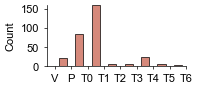

In [16]:
tps = ['V', 'P', 'T0','T1','T2','T3','T4','T5','T6']
plt.figure(figsize=(1.8,0.8))
sns.barplot(x='stage',y='count', data = data4, order=col, width=0.5,
linewidth = 0.5, edgecolor = 'k', color = '#E57F6C')
plt.xticks([i-0.5 for i in[0,1,2,3,4,5,6,7,8]], tps)
# plt.xticks(col, rotation=90)
plt.xlim(-1,7.5)
plt.ylim(0,160)
plt.yticks([0, 50,100,150])
plt.xlabel('')
plt.ylabel('Count')
# plt.savefig('./5_Figure_Antisense/Fig2b_asRNA_stage_count.pdf',  bbox_inches = 'tight')
# plt.show()

## Fig. S2c TIP1 antisense reads ratio

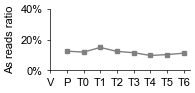

In [ ]:
plt.figure(figsize=(1.8, 0.8))
plt.plot(dfatr.loc['YBR067C',timepoints], color='gray',
    linewidth=1, alpha=1, marker='s', markersize=3)
plt.xticks(range(9), ['V', 'P', 'T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6'])
plt.ylim(0,0.4)
plt.ylabel('As reads ratio')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
# plt.savefig('./5_Figure_Antisense/FigS2c_TIP1_AsRNA ratio.pdf',  bbox_inches = 'tight')
# plt.show()

## Fig. 2d TIP1-As MS2 imaging

In [ ]:
# shell script to remove name characters
# for f in *; do
#   new=$(echo "$f" | iconv -c -t ASCII//TRANSLIT)
#   [ "$f" != "$new" ] && mv "$f" "$new"
# done

In [ ]:
# Function to convert yellow pixels to white pixels
def yellow2white(file):
    img = Image.open(file)
    img_np = np.array(img)
    # Only replace channels for pure yellow pixels
    mask = (img_np[..., 0] >= 255) & (img_np[..., 1] >= 255) & (img_np[..., 2] < 20)
    img_np[mask] = [255, 255, 255]
    Image.fromarray(img_np).save(file.replace('.tif', '_white.tif'))
# files = [czi_path + 'TIP1/' + i for i in os.listdir(czi_path+'TIP1/') if i.endswith('Composite.tif')]
# for i in files:
#     yellow2white(i)

## Fig. 3e QPCR motif deletion

In [ ]:
## motif sequence
{
'AKR2' : 'TGCACAAAA',
'FMP33' : 'GACACAAAA',
'LAP4': 'GTCACAAAA',
'NDJ1' : 'ACCACAAAC',
'NOG1': 'GTCACAAAA',
'NRG1': 'ACCGCAAAT',
'NRG1': 'ACCGCAAAT & ATTGCAAAA',
'TAF1': 'GACACAAAT',
'TAF1': 'GACACAAAT & GTCACAAAT'
    }
['AKR2', 'FMP33', 'LAP4', 'NDJ1', 'NOG1', 'NRG1', 'TAF1']
['YOR034C', 'YJL161W', 'YKL103C', 'YOL104C', 'YPL093W', 'YDR043C', 'YGR274C']

In [28]:
qresults = wd+'MSE_qPCR_Raw data summary/Manuscript_dsRNA_qPCR_raw_2.xlsx'
dfq = pd.read_excel(qresults, sheet_name='Sheet3')
## average CT of TecReplicate
dfq = dfq.groupby(['Sample', 'Timepoint', 'Gene'])['CT'].mean().reset_index()
## normalized by ACT1 -- delta CT
dfqact = dfq[dfq['Gene'] == 'ACT1'][['Sample', 'Timepoint', 'CT']].rename(columns={'CT': 'Actin_CT'})
dfq = dfq[dfq['Gene'] != 'ACT1']
dfq = dfq.merge(dfqact, on=['Sample', 'Timepoint'])
dfq['dCT'] = dfq['Actin_CT'] - dfq['CT']
## normalized by 6h -- delta delta CT
dfq6h = dfq[dfq['Timepoint'] == '6h'][['Sample', 'Gene', 'dCT']].rename(columns={'dCT': '6h_dCT'})
dfq = dfq[dfq['Timepoint'] != '6h']
dfq = dfq.merge(dfq6h, on=['Sample', 'Gene'])
## Fold change
dfq['ddCT'] = dfq['dCT'] - dfq['6h_dCT']
dfq['FC'] = 2**dfq['ddCT']
dfq['Locus'] = dfq['Gene'].str.strip('DM_')

dfq['Group'] = 'WT' 
dfq.loc[dfq['Gene'].str.contains('_'), 'Group'] = 'DM'
dfq = dfq[dfq.Gene != 'DDM_NRG1']
# dfq.to_excel(wd+'MSE_qPCR_Raw data summary/Manuscript_dsRNA_qPCR_processed.xlsx')

['**', '****', '**', '**', '*', '*']


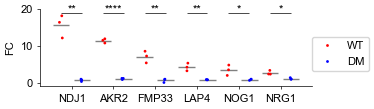

In [29]:
genes = ['NDJ1', 'AKR2', 'FMP33', 'LAP4', 'NOG1', 'NRG1']
pvalue = []
order = []
fc = []
for i in genes:
    wt = dfq.loc[dfq['Gene'] == i, 'FC']
    mut = dfq.loc[dfq['Gene'] == 'DM_'+i, 'FC']
    fc.append(mut.mean() / wt.mean())
    # print(stats.ttest_rel(wt, mut))
    pvalue.append(stats.ttest_ind(wt, mut)[1])
    order.append(i)
    order.append('DM_'+i)
pvalue = [p_to_significance(p) for p in pvalue]
print(pvalue)

dfplot = dfq[dfq.Locus.isin(genes)]
plt.figure(figsize=(3.5, 1))
p = sns.stripplot(x='Gene', y='FC', hue='Group', data=dfplot, 
    size=2, palette=['red', 'blue'], legend=True,zorder=5,
    order = order)
sns.boxplot(showmeans=True, meanline=True,
    meanprops={'color': 'gray', 'ls': '-', 'lw': 1},
    medianprops={'visible': False},
    whiskerprops={'visible': False},
    zorder=1,x="Gene",y="FC",
    data=dfplot,showfliers=False,showbox=False,
    showcaps=False,hue='Group',ax=p, legend=False,
    order = order)
plt.xticks([0.5, 2.5, 4.5, 6.5, 8.5, 10.5],)

plt.xlabel('')

plt.ylim(-1,20)
# plt.yticks([0, 10, 20])
for i in range(6):
    plot_sig(2*i,2*i+1,19,pvalue[i])

plt.legend(loc=(1,0.2))
# plt.savefig(fwd+'Fig3_motif_deletion_qPCR.pdf')
# plt.show()

['*', '*']


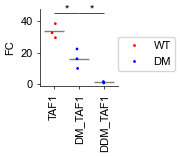

In [30]:
# genes = ['NRG1', 'DM_NRG1', 'DDM_NRG1']
genes = ['TAF1', 'DM_TAF1', 'DDM_TAF1']
pvalue = []
wt = dfq.loc[dfq['Gene'] == 'TAF1', 'FC']
mut = dfq.loc[dfq['Gene'] == 'DM_TAF1', 'FC']
pvalue.append(stats.ttest_ind(wt, mut)[1])
wt = dfq.loc[dfq['Gene'] == 'DM_TAF1', 'FC']
mut = dfq.loc[dfq['Gene'] == 'DDM_TAF1', 'FC']
pvalue.append(stats.ttest_ind(wt, mut)[1])
pvalue = [p_to_significance(p) for p in pvalue]
print(pvalue)

dfplot = dfq[dfq.Locus.isin(genes)]
plt.figure(figsize=(1, 1))
p = sns.stripplot(x='Gene', y='FC', hue='Group', data=dfplot, 
    size=2, palette=['red', 'blue'], legend=True,zorder=5)
sns.boxplot(showmeans=True, meanline=True,
    meanprops={'color': 'gray', 'ls': '-', 'lw': 1},
    medianprops={'visible': False},
    whiskerprops={'visible': False},
    zorder=1,x="Gene",y="FC",
    data=dfplot,showfliers=False,showbox=False,
    showcaps=False,hue='Group',ax=p, legend=False)
plt.xticks(rotation = 90)

plt.xlabel('')
# plt.ylim(-1,20)
# plt.yticks([0, 10, 20])
for i in range(2):
    plot_sig(i,i+1,45,pvalue[i])
plt.legend(loc=(1,0.2))
# plt.savefig(fwd+'Fig3_TAF1_deletion_qPCR.pdf')
# plt.show()

## Fig. S3a Top5 enriched motif

In [ ]:
# de novo enrichment of motif
# streme \
#   --p P-T0_gene_3end_1000bp_antisense.fasta \
#   --n P-T0_background_shuf_k2.fasta \
#   --dna \
#   --minw 6 \
#   --maxw 10 \
#   --nmotifs 8 \
#   --oc P-T0_streme_out_background

# plot motif
# meme2images MA0412.1.meme plot/

# search given motif
# fimo --norc motif.meme promoter.fa

In [ ]:
files = [i for i in os.listdir('/Users/wuhao/Data/Yeast/5_Figure_Antisense/MEME/Motif/') if i.endswith('meme')]
for i in files:
    print('meme2images ' + i + ' ' + i.replace('.meme','') + '/')

meme2images NDT80.MA0343.2.meme NDT80.MA0343.2/
meme2images 3-CGCCWCCG.meme 3-CGCCWCCG/
meme2images 2-TCCATGAA.meme 2-TCCATGAA/
meme2images 2-GCCTCCTCAC.meme 2-GCCTCCTCAC/
meme2images 4-CCTATGCATA.meme 4-CCTATGCATA/
meme2images 1-CGCGGCACAA.meme 1-CGCGGCACAA/
meme2images 5-AAAGACGCGT.meme 5-AAAGACGCGT/
meme2images 1-CGGCGGCTAA.meme 1-CGGCGGCTAA/
meme2images UME6.MA0412.1.meme UME6.MA0412.1/
meme2images 4-YGACACAAAA.meme 4-YGACACAAAA/
meme2images 5-AGAGTGGAG.meme 5-AGAGTGGAG/
meme2images 3-ATTAGGGAG.meme 3-ATTAGGGAG/


In [986]:
files = [i for i in os.listdir('/Users/wuhao/Data/Yeast/5_Figure_Antisense/MEME/Motif/') if i.endswith('meme') and '-' in i]
for i in files:
    print('tomtom -oc ' + i.replace('.meme','') + '_tomtom_out -thresh 1 -evalue -dist pearson ' + i + ' JASPAR2024_CORE_fungi_non-redundant_pfms_meme.txt')

tomtom -oc 3-CGCCWCCG_tomtom_out -thresh 1 -evalue -dist pearson 3-CGCCWCCG.meme JASPAR2024_CORE_fungi_non-redundant_pfms_meme.txt
tomtom -oc 2-TCCATGAA_tomtom_out -thresh 1 -evalue -dist pearson 2-TCCATGAA.meme JASPAR2024_CORE_fungi_non-redundant_pfms_meme.txt
tomtom -oc 2-GCCTCCTCAC_tomtom_out -thresh 1 -evalue -dist pearson 2-GCCTCCTCAC.meme JASPAR2024_CORE_fungi_non-redundant_pfms_meme.txt
tomtom -oc 4-CCTATGCATA_tomtom_out -thresh 1 -evalue -dist pearson 4-CCTATGCATA.meme JASPAR2024_CORE_fungi_non-redundant_pfms_meme.txt
tomtom -oc 1-CGCGGCACAA_tomtom_out -thresh 1 -evalue -dist pearson 1-CGCGGCACAA.meme JASPAR2024_CORE_fungi_non-redundant_pfms_meme.txt
tomtom -oc 5-AAAGACGCGT_tomtom_out -thresh 1 -evalue -dist pearson 5-AAAGACGCGT.meme JASPAR2024_CORE_fungi_non-redundant_pfms_meme.txt
tomtom -oc 1-CGGCGGCTAA_tomtom_out -thresh 1 -evalue -dist pearson 1-CGGCGGCTAA.meme JASPAR2024_CORE_fungi_non-redundant_pfms_meme.txt
tomtom -oc 4-YGACACAAAA_tomtom_out -thresh 1 -evalue -dist pear

## Fig. 4a sense RNA abundance clusters


In [107]:
df = pd.read_excel('./3_Table_Antisense/Supplementary Tables.xlsx', 
sheet_name = 'Table S2', index_col= 'Gene_ID')

tps = ['YPD', '0h', '6h', '7h', '7h25', '7h5', '8h25', '8h75', '9h5']
dfRNA = pd.read_csv('./3_Table_Antisense/TPM_sense.csv', index_col='Geneid')
dfanti = pd.read_csv('./3_Table_Antisense/TPM_anti.csv', index_col='Geneid')
dfboth = pd.read_csv('./3_Table_Antisense/TPM_both.csv', index_col='Geneid')
dfRNA=dfRNA[tps]
dfanti=dfanti[tps]
dfboth=dfboth[tps]
# RNAseq cutoff = 10 TPM
dfboth = dfboth[dfboth>=10]
dfatr = dfanti/dfboth
dfatr['dltAntiRatio'] = dfatr.max(axis=1) - dfatr.min(axis=1)

dfatr['Gene_symbol'] = dfatr.apply(lambda x: df.loc[x.name, 'Gene_symbol'] \
    if x.name in df.index.to_list() else np.nan, axis = 1)
dfatr = dfatr.sort_values('dltAntiRatio', ascending=False)

data = dfatr.loc[(dfatr['dltAntiRatio']>=0.2), tps]
data = data[data.isna().sum(axis = 1)<=1]
print(data.shape)
# data.to_csv('./3_Table_Antisense/heatmap/dltAntiRatioover0.2_7.5.table', sep = '\t')

(405, 9)


In [47]:
cls2 = pd.read_table('./3_Table_Antisense/heatmap/dltAntiRatioover0.2_7.5_increase.cdt')
genes = df[['Gene_symbol']]
senseRNA_TPM = dfRNA[dfRNA.index.isin(cls2.Geneid)]
senseRNA_TPM.index = genes.loc[senseRNA_TPM.index, 'Gene_symbol'].to_list()
senseRNA_TPM = senseRNA_TPM.apply(zscore, axis = 1)
# senseRNA_TPM.to_csv('./3_Table_Antisense/senseRNA313_TPM.tsv', sep='\t')


In [ ]:
dfc = pd.read_table('./3_Table_Antisense/senseRNA313_TPM.cdt', index_col=0)
dfc = dfc[['NAME', 'YPD', '0h', '6h', '7h', '7h25', '7h5',
    '8h25', '8h75', '9h5']]
dfc.columns = ['Gene symbol', 'V', 'P', 'T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6']
dfc = dfc.dropna()
dfc['plused expression'] = np.nan
dfc.loc[dfc['Gene symbol'].isin(dfc1.NAME), 'plused expression'] = 'T0'
dfc.loc[dfc['Gene symbol'].isin(dfc2.NAME), 'plused expression'] = 'T1'
# dfc.to_excel('./3_Table_Antisense/TableS6_senseRNA312_TPM.xlsx')

/var/folders/rw/85k6y2vs37x81n21hjm129fm0000gn/T/ipykernel_63671/3417831940.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'T0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dfc.loc[dfc['Gene symbol'].isin(dfc1.NAME), 'plused expression'] = 'T0'


In [78]:
dfc1 = pd.read_table('./3_Table_Antisense/senseRNA313_TPM_data_cluster1.cdt')
dfc2 = pd.read_table('./3_Table_Antisense/senseRNA313_TPM_data_cluster2.cdt')
dfc1 = dfc1.loc[1:]
dfc2 = dfc2.loc[1:]

In [81]:
dfc2

,GID,null,NAME,GWEIGHT,YPD,0h,6h,7h,7h25,7h5,8h25,8h75,9h5
1,GENE210X,ALD2,ALD2,1.0,-0.854642,-0.490814,2.443865,0.792096,-0.368536,-0.521199,-0.940505,-0.289904,0.229638
2,GENE252X,NDJ1,NDJ1,1.0,-0.888555,-0.763130,2.647929,0.322953,-0.055508,-0.105618,-0.227967,-0.382820,-0.547283
3,GENE307X,YPR002C-A,YPR002C-A,1.0,-0.572406,-0.179907,2.791622,-0.146951,-0.100181,-0.373539,-0.445391,-0.443650,-0.529595
4,GENE154X,YKL068W-A,YKL068W-A,1.0,-1.224059,0.025597,2.626456,-0.096343,0.068160,-0.408598,-0.082602,-0.420663,-0.487948
5,GENE256X,YOR008W-B,YOR008W-B,1.0,-0.470630,-0.121132,2.637081,0.430474,-0.053056,-0.341587,-0.497449,-0.751054,-0.832645
6,GENE238X,NPR1,NPR1,1.0,0.035371,-0.447298,2.509402,0.699154,-0.168789,-0.380328,-0.487265,-0.717401,-1.042847
7,GENE189X,ATP10,ATP10,1.0,-0.329158,-0.614802,2.417330,0.894996,0.263792,-0.472017,-0.728489,-0.612694,-0.818959
8,GENE20X,MGR1,MGR1,1.0,-0.498036,-0.274820,2.431121,0.938489,0.051908,-0.385964,-0.620503,-0.831921,-0.810275
9,GENE308X,YPR012W,YPR012W,1.0,-0.373573,0.417480,2.172064,0.835939,-0.400635,-0.785098,0.317541,-1.030752,-1.152966
10,GENE64X,SWR1,SWR1,1.0,-0.005328,0.018357,2.562987,0.189137,-0.562728,-0.935337,0.119779,-0.356243,-1.030624


In [1054]:
print(dfc1.shape, dfc2.shape)

(42, 13) (35, 13)


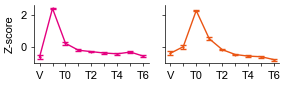

In [ ]:
tps = ['V', 'P', 'T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6']
tps1 = ['V', '', 'T0', '', 'T2', '', 'T4', '', 'T6']
timepoints = ['YPD', '0h', '6h',  '7h', '7h25', '7h5', '8h25', '8h75', '9h5']

fig, axes = plt.subplots(1, 2, 
    figsize=(3, 1), sharey=True)

# Cluster 1
mean1 = dfc1[timepoints].mean()
sem1 = dfc1[timepoints].sem()
# axes[0].plot(dfc1[timepoints].mean(), marker='s', 
#     linewidth=1, markersize=3, color='#E4007F')
axes[0].errorbar(
    range(9), mean1, yerr=sem1, marker='o',
    linewidth=1, markersize=0.5, color='#E4007F', capsize=2
)
axes[0].set_xticks(range(9))
axes[0].set_xticklabels(tps1)
axes[0].set_ylabel('Z-score')

# Cluster 2
# axes[1].plot(dfc2[timepoints].mean(), marker='s', 
#     linewidth=1, markersize=3, color='#EA5514')
mean2 = dfc2[timepoints].mean()
sem2 = dfc2[timepoints].sem()
axes[1].errorbar(
    range(9), mean2, yerr=sem2, marker='o',
    linewidth=1, markersize=0.5, color='#EA5514', capsize=2
)

axes[1].set_xticks(range(9))
axes[1].set_xticklabels(tps1)

plt.tight_layout()
# plt.savefig('./5_Figure_Antisense/Fig4a_RNA_abundance_2clusters.pdf', bbox_inches = 'tight')
# plt.show()

## Fig. S4b TUMs lacking antisense transcription

In [ ]:
# dfr1 = pd.read_table('./3_Table_Antisense/log2RNA_Seq_9cond_max10_maxdiff8_allpresent_euc_cent_data_TUMs.cdt')
# # dfr1 = dfr1.loc[1:]
# dfr1 = pd.concat([dfr1.loc[[0]], dfr1[~dfr1.GENE_ID.isin(cls2.Geneid)]])
# # dfr1.to_csv('./3_Table_Antisense/log2RNA_Seq_9cond_max10_maxdiff8_allpresent_euc_cent_data_TUMs_antisense_removed.cdt', index=False, sep='\t')

# dfr1 = dfRNA[dfRNA.index.isin(dfr1.GENE_ID)]
# dfr1 = np.log2(dfr1+1)
# dfr1.to_csv('./3_Table_Antisense/log2RNA_Seq_9cond_max10_maxdiff8_allpresent_antisense_removed.table', index=True, sep='\t')

In [10]:
dfr1 = pd.read_table('./3_Table_Antisense/log2RNA_Seq_9cond_max10_maxdiff8_allpresent_antisense_removed.table', index_col=0)

In [12]:
dfr1.shape

(1044, 9)

## Fig. 4b and 4c dsRNA degradation pathway

In [1124]:
czi_path = './5_Figure_Antisense/20220314 good confocol dsRNA along the timecourse/'
files = [czi_path + 'cell marker/' + i for i in os.listdir(czi_path+'cell marker/') if i.endswith('Composite.tif')]
for i in files[0:-1]:
    yellow2white(i)
Green2Red(files[-1])

## Fig. 4d NDJ1 and AKR2 antisense ratio

In [ ]:
# i = 'YDR506C'
# id = genes.loc[i, 'Gene_symbol']
tps = ['V', 'P', 'T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6']
tps1 = ['V', '', 'T0', '', 'T2', '', 'T4', '', 'T6']
timepoints = ['YPD', '0h', '6h',  '7h', '7h25', '7h5', '8h25', '8h75', '9h5']

def plot_TPM_asRatio(geneid):
    id = geneid
    i = genes[genes.Gene_symbol == id].index[0]
    # Use same subplot, left y-axis for TPM, right y-axis for Anti ratio
    fig, ax = plt.subplots(figsize=(2.2, 0.8))

    # Left axis: sense RNA TPM
    ax.plot(range(9), dfRNA.loc[i, timepoints], color='#EA5514', 
        marker='s', markersize=3, linewidth=1, label='TPM')
    # ax.set_ylabel('TPM', color='#EA5514')
    ax.tick_params(axis='y', labelcolor='#EA5514')

    # Share x-axis labels
    ax.set_xticks(range(9))
    ax.set_xticklabels(tps, rotation=0)
    ax.set_title(id)
    ax.set_zorder(3)
    ax.patch.set_visible(False)

    # Right axis: antisense ratio
    ax2 = ax.twinx()
    ax2.plot(range(9), dfatr.loc[i, timepoints], color='#3399CC', 
        marker='s', markersize=3, linewidth=1, label='Anti')
    # ax2.set_ylabel('Antisense reads ratio', color='#3399CC')
    ax2.tick_params(axis='y', labelcolor='#3399CC')
    # ax2.set_ylabel('As reads ratio', color='#3399CC')
    ax2.set_zorder(2)
    ax2.patch.set_visible(False)
    # Ensure right spine and ticks are visible
    ax2.spines['right'].set_visible(True)
    ax2.spines['top'].set_visible(False)
    ax2.yaxis.set_ticks_position('right')
    ax2.yaxis.set_label_position('right')

    # Format right axis ticks as percentage (assuming data is between 0-1)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0,decimals=0))

    # Optional: merge legends
    # lines, labels_ = ax.get_legend_handles_labels()
    # lines2, labels2_ = ax2.get_legend_handles_labels()
    # ax.legend(lines + lines2, labels_ + labels2_, loc='upper right', fontsize=6, frameon=False)
    # plt.savefig('./5_Figure_Antisense/Fig4_'+id+'_RNAabundance_asRation.pdf')
    # plt.show()

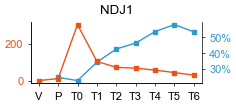

In [1167]:
geneid = 'NDJ1'
plot_TPM_asRatio(geneid)

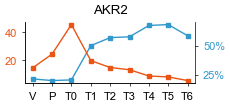

In [1168]:
geneid = 'AKR2'
plot_TPM_asRatio(geneid)

In [8]:
czi_path = './5_Figure_Antisense/20220314 good confocol dsRNA along the timecourse/'
files = [czi_path + 'NDJ1/' + i for i in os.listdir(czi_path+'NDJ1/') if i.endswith('Composite.tif')]
for i in files:
    yellow2white(i)

## Fig. 4E ChIP-Peaks

In [103]:
dfp1 = pd.read_table('/Users/wuhao/Data/Yeast/3_Table_Antisense/peaks/SRR5061151_Ndt80myc_peaks.narrowPeak', header=None)
dfp1.columns = ['chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'signalValue', '-log10_pValue', '-log10_qValue', 'peak']
dfp1['TF']= 'Ndt80'
dfp2 = pd.read_table('/Users/wuhao/Data/Yeast/3_Table_Antisense/peaks/SRR10423772_Ume6_peaks.narrowPeak', header=None)
dfp2.columns = ['chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'signalValue', '-log10_pValue', '-log10_qValue', 'peak']
dfp2['TF']= 'Ume6'

In [ ]:
# dfp3 = pd.concat([dfp1, dfp2])
# dfp3.to_excel('/Users/wuhao/Data/Yeast/3_Table_Antisense/TableS7_TF_peaks_Ndt80_Ume6.xlsx', index=False)

## Fig. S4c RNY1 protein abundance

In [5]:
dfsk1 = pd.read_csv('./3_Table/MS_SK1.csv')
dfsk1 = dfsk1.set_index('geneSymbol')
dfsk1 = dfsk1[[i for i in dfsk1.columns if '02' in i and 'Norm' in i]]
dfsk1.columns = [i.split()[0].split('_')[0] for i in dfsk1.columns]

genes = ['NDT80', 'UME6', 'IME4','PUT3','TAF1', 'NDJ1', 'AKR2', 'USB1', 'MAG1', 'NAM7', 'MAG2']
dfsk1.loc[genes,['Vexp', 'M0h', 'M1.5h', 'M3h', 'M4.5h', 'M6h', 'M8h', 'M10h']]

dfsk1.loc['RNY1'][:-2]

/var/folders/rw/85k6y2vs37x81n21hjm129fm0000gn/T/ipykernel_25819/3459376263.py:1: DtypeWarning: Columns (93,94,95,96,97,99,113,114) have mixed types. Specify dtype option on import or set low_memory=False.
  dfsk1 = pd.read_csv('./3_Table/MS_SK1.csv')


Vexp      88.810848
M0h      198.540401
M1.5h    247.493203
M3h      296.185605
M4.5h    373.838619
M6h      422.970920
M8h      416.344315
M10h     590.150167
Name: RNY1, dtype: float64

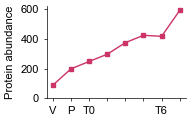

In [6]:
i = 'YPL123C'
plt.figure(figsize=(1.8, 1.2))
plt.plot(dfsk1.loc['RNY1'][:-2], marker='s',linewidth=1, 
    markersize=3, color='#CC3366')
# plt.plot(dfanti.loc[i], marker='s', markersize=3, color='gray')
# plt.xticks(range(9), ['V', 'P', 'T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6'])
plt.ylim(0,620)
plt.xticks(range(8), ['V', 'P', 'T0','','','','T6',''])
plt.ylabel('Protein abundance')
# plt.savefig('./5_Figure_Antisense/Fig4_RNY1_protein_abundance.pdf')
plt.show()

# Nanopore data processing

In [ ]:
# # prepare gff for gffcompare
# gff = pd.read_table('./2_Anno/sk1_revised_100331_filtered.gff', 
# comment='#', header=None)
# # gff=gff[gff[2].isin(['gene'])]
# # gff[2] = 'transcript'
# gff=gff[gff[2].isin(['gene', 'CDS', 'intron', 'pseudogene'])]
# # gff.to_csv('./2_Anno/sk1_gene.gff', header=None,index=False,sep='\t')

In [144]:
# #-------Stringtie output processing----------
# #-------only keep transcript with TPM >=2 at any sample--------
# col=['seqname', 'source', 'feature', 'start', 'end', 
# 'score', 'strand', 'frame', 'attribute']
# for t in ['TYPD', 'T6h', 'T8h25']:
#     gtf=pd.read_table('./3_Table_Antisense/5_stringtie/'+t+'_stringtie.gtf', 
#     comment='#', header=None,names=col)
#     gtf['TPM'] = gtf['attribute'].str.extract(r'TPM "([^"]+)"')
#     gtf['TPM'] = gtf['TPM'].astype(float)

#     gtf['cov'] = gtf['attribute'].str.extract(r'cov "([^"]+)"')
#     gtf['cov'] = gtf['cov'].astype(float)

#     gtf['transcript_id'] = gtf['attribute'].str.extract(r'transcript_id "([^"]+)"')
#     gtf=gtf[gtf.transcript_id.isin(gtf.loc[gtf['TPM']>=2,'transcript_id'])]
#     gtf[col].to_csv('./3_Table_Antisense/5_stringtie/'+t+'_stringtie_TPM2.gtf', header=None,index=False,sep='\t',
#                     quotechar='"', quoting=csv.QUOTE_NONE, escapechar='\\')

In [149]:
# classify transcripts in gtf
df = pd.read_excel('./3_Table_Antisense/Supplementary Tables.xlsx', 
    sheet_name = 'Table S2', index_col= 'Gene_ID')

In [ ]:
# identify antisense and conresopnding gene locus
# bedtools intersect -a sk1_gene.gtf -b TYPD_stringtie_TPM2.gtf T6h_stringtie_TPM2.gtf T8h25_stringtie_TPM2.gtf -S -f 0.5 -wo -names TYPD T6h T8h25 > gtf_intersect.table
# -sorted
# -f	Minimum overlap required as a fraction of A. Default is 1E-9 (i.e. 1bp).
# -S	Require different strandedness. That is, only report hits in B that overlap A on the _opposite_ strand. By default, overlaps are reported without respect to strand.
# -F	Minimum overlap required as a fraction of B. Default is 1E-9 (i.e., 1bp).
# -wa	Write the original entry in A for each overlap.
# -wo	Write the original A and B entries plus the number of base pairs of overlap between the two features. Only A features with overlap are reported. Restricted by -f and -r.
# -C	For each entry in A, separately report the number of overlaps with each B file on a distinct line. Reports 0 for A entries that have no overlap with B. Overlaps restricted by -f, -F, -r, and -s.


In [16]:
wd = './3_Table_Antisense/5_stringtie/'
df1 =  pd.read_table(wd+'gtf_intersect.table', header = None)
df1 = df1[df1[12] == 'exon']
df1['locus'] = df1[8].str.extract(r'transcript_id\s+(\S+);')

In [ ]:
def split_bedgraph_by_strand(input_bedgraph, output_fwd, output_rev):
    """
    Split BedGraph file into two files by strand: forward and reverse.

    Parameters:
        input_bedgraph: Input BedGraph file path (assuming 5th column is strand)
        output_fwd: Output forward strand file path
        output_rev: Output reverse strand file path
    """
    with open(input_bedgraph, 'r') as infile, \
        open(output_fwd, 'w') as fwd_out, \
        open(output_rev, 'w') as rev_out:
        
        for line in infile:
            if line.startswith('#') or line.strip() == '':
                continue  # Skip comments and empty lines
            
            fields = line.strip().split('\t')
            if len(fields) < 5:
                # If fewer than 5 columns, skip or raise error
                continue
            
            strand = fields[4]
            if strand == '+':
                fwd_out.write(line)
            elif strand == '-':
                rev_out.write(line)
            else:
                # If other strand symbols, choose to skip or handle separately
                pass

In [ ]:
# normalize start site count to TPM
tps = ['TYPD', 'T6h', 'T8h25']
for t in tps:
    f1 = './3_Table_Antisense/Nanopore_Bam/' + t + '_start_sites.bed'
    dfypd = pd.read_table(f1, comment='*', header=None)
    total = dfypd[3].sum()
    print(dfypd[3].sum())
    dfypd[3] = dfypd[3] * (10000000 / total)
    print(dfypd[3].sum())
    dfypd.to_csv('./3_Table_Antisense/Nanopore_Bam/' + t + '_start_sites_normalized.bedgraph', sep='\t', header=None, index=None)

9007389
9999999.999999996
10161818
10000000.0
10329869
10000000.000000004


In [ ]:
## Split BedGraph file by strand
tps = ['TYPD', 'T6h', 'T8h25']
for t in tps:
    f1 = './3_Table_Antisense/Nanopore_Bam/'+t+'_start_sites_normalized.bedgraph'
    f2 = './3_Table_Antisense/Nanopore_Bam/'+t+'_start_sites_fwd.bedgraph'
    f3 = './3_Table_Antisense/Nanopore_Bam/'+t+'_start_sites_rev.bedgraph'
    split_bedgraph_by_strand(f1, f2, f3)

In [ ]:
tps=['TYPD', 'T6h', 'T8h25']
wd = './3_Table_Antisense/5_stringtie/'
for t in tps:
    df1 = pd.read_table(wd+'Merge_stringtie.gtf.'+t+'_stringtie_TPM2.gtf.tmap')
    df1 = df1[df1.ref_id.isin(df.index)]
    df1.to_csv(wd + 'Stringtie_'+t+'_TPM2.tmap', sep='\t')
    with open(wd+'Stringtie_'+t+'_TPM2_x.table','w') as f1:
        f1.write('\n'.join(df1[df1.class_code=='x']['ref_id'].unique()))
# use the output antisense RNA for veen plot at https://bioinformatics.psb.ugent.be/webtools/Venn/
# GO enrichment analysis 

In [ ]:
# wd = './3_Table_Antisense/5_stringtie/'
# t = 'TYPD'
# genesYPD = pd.read_table(wd+'Stringtie_'+t+'_TPM2_x.table', header=None)[0].unique()
# t = 'T6h'
# genes6h = pd.read_table(wd+'Stringtie_'+t+'_TPM2_x.table', header=None)[0].unique()
# t = 'T8h25'
# genes8h25 = pd.read_table(wd+'Stringtie_'+t+'_TPM2_x.table', header=None)[0].unique()

# unique8h25 = np.setdiff1d(genes8h25, np.union1d(genesYPD, genes6h))
# np.savetxt(wd+'unique8h25.txt', unique8h25, fmt='%s', delimiter='\t')

# unique6h = np.setdiff1d(genes6h, np.union1d(genesYPD, genes8h25 ))
# np.savetxt(wd+'unique6h.txt', unique6h, fmt='%s', delimiter='\t')


In [23]:
# anti sense ratio nanopore
col=['TYPD', 'T6h', 'T8h25']
rna=pd.read_table('./3_Table_Antisense/5_stringtie/A14201_ONT_sense_count.table',comment='#')
rna.columns = ['Geneid', 'Chr', 'Start', 'End', 'Strand', 'Length', 'TYPD', 'T6h', 'T8h25']
rna=rna.set_index('Geneid')
anti=pd.read_table('./3_Table_Antisense/5_stringtie/A14201_ONT_anti_count.table',comment='#')
anti.columns = ['Geneid', 'Chr', 'Start', 'End', 'Strand', 'Length', 'TYPD', 'T6h', 'T8h25']
anti=anti.set_index('Geneid')
dfanti = anti[col]/(rna[col]+anti[col])
dfanti.loc[['YGL192W', 'YLR132C', 'YDL036C', 'YJR105W', 'YOL104C', 'YOL105C', 'YPL274W', 'YDR272W', 'YGR274C']]

,TYPD,T6h,T8h25
Geneid,,,
YGL192W,0.571429,0.157828,0.136872
YLR132C,0.100000,0.989583,0.961686
YDL036C,0.381166,0.753591,0.171123
YJR105W,0.000809,0.049834,0.318497
YOL104C,0.250000,0.003035,0.269126
YOL105C,0.034014,0.006276,0.894807
YPL274W,0.141221,0.119048,0.877446
YDR272W,0.029412,0.014760,0.715969
YGR274C,0.015873,0.032941,0.675420


## fetch promoter sequence for motif enrichment 

In [ ]:
# antisense P-T0
# antisense T0-T1

In [ ]:
# from Bio import SeqIO
# from Bio.Seq import Seq

# # Input files
# tps1 = 'P-T0'
# gff_file = './2_Anno/sk1_revised_100331_filtered.gff'
# fasta_file = './2_Anno/sk1_revised_100331_filtered.fasta'
# target_genes = set(data3[data3.stage == tps1].index) 
# # target_genes = set([i for i in df.index if i not in data3.index])

# # Read genome sequences to dictionary
# genome_dict = SeqIO.to_dict(SeqIO.parse(fasta_file, "fasta"))

# # Parse GFF
# gene_coords = []
# with open(gff_file) as gff:
#     for line in gff:
#         if line.startswith("#"):
#             continue
#         chrom, source, feature, start, end, score, strand, phase, attributes = line.strip().split("\t")
#         if feature != "gene":
#             continue
#         # Adjust ID extraction method according to actual GFF format
#         if "ID=" in attributes:
#             gid = attributes.split("ID=")[1].split(";")[0]
#         elif "gene=" in attributes:
#             gid = attributes.split("gene=")[1].split(";")[0]
#         else:
#             continue
#         if gid in target_genes:
#             gene_coords.append((gid, chrom, int(start), int(end), strand))

# # Prepare two lists
# records_3end = []
# records_5end = []

# for gid, chrom, start, end, strand in gene_coords:
#     seq = genome_dict[chrom].seq
    
#     if strand == "+":  
#         # 3' downstream 1000bp (antisense)
#         seq_region_3 = seq[end:end+1000]
#         antisense_seq = seq_region_3.reverse_complement()
#         records_3end.append(f">{gid}_3end_1000bp_antisense\n{antisense_seq}")
        
#         # 5' upstream 1000bp (sense)
#         start_pos = max(0, start - 1000 - 1)
#         seq_region_5 = seq[start_pos:start]
#         records_5end.append(f">{gid}_5end_1000bp\n{seq_region_5}")
        
#     else:  
#         # 3' downstream 1000bp (antisense, for minus strand gene 3' downstream is upstream of start)
#         start_pos_3 = max(0, start - 1000 - 1)
#         seq_region_3 = seq[start_pos_3:start]
#         antisense_seq = seq_region_3  # Already antisense
#         records_3end.append(f">{gid}_3end_1000bp_antisense\n{antisense_seq}")
        
#         # 5' upstream 1000bp (sense direction, for minus strand gene it's reverse complement of downstream of end)
#         seq_region_5 = seq[end:end+1000]
#         sense_seq = seq_region_5.reverse_complement()
#         records_5end.append(f">{gid}_5end_1000bp\n{sense_seq}")

# # Save two files
# with open(f"./5_Figure_Antisense/MEME/{tps1}_gene_3end_1000bp_antisense.fasta", "w") as out3:
#     out3.write("\n".join(records_3end))

# with open(f"./5_Figure_Antisense/MEME/{tps1}_gene_5end_1000bp.fasta", "w") as out5:
#     out5.write("\n".join(records_5end))

# print(f"Saved 3' end sequences to {tps1}_gene_3end_1000bp_antisense.fasta")
# print(f"Saved 5' end sequences to {tps1}_gene_5end_1000bp.fasta")


已保存 3' 端序列到 P-T0_gene_3end_1000bp_antisense.fasta
已保存 5' 端序列到 P-T0_gene_5end_1000bp.fasta


In [ ]:
from Bio import SeqIO
from Bio.Seq import Seq

# Input files
# tps1 = 'P-T0'
tps1 = 'background'
gff_file = './2_Anno/sk1_revised_100331_filtered.gff'
fasta_file = './2_Anno/sk1_revised_100331_filtered.fasta'
# target_genes = set(data3[data3.stage == tps1].index) 
target_genes = set([i for i in df.index if i not in data3.index])
# Read genome sequences to dictionary
genome_dict = SeqIO.to_dict(SeqIO.parse(fasta_file, "fasta"))

# Parse GFF
gene_coords = []
with open(gff_file) as gff:
    for line in gff:
        if line.startswith("#"):
            continue
        chrom, source, feature, start, end, score, strand, phase, attributes = line.strip().split("\t")
        if feature != "gene":
            continue
        # Adjust ID extraction method according to actual GFF format
        if "ID=" in attributes:
            gid = attributes.split("ID=")[1].split(";")[0]
        elif "gene=" in attributes:
            gid = attributes.split("gene=")[1].split(";")[0]
        else:
            continue
        if gid in target_genes:
            gene_coords.append((gid, chrom, int(start), int(end), strand))

# Extract 3' downstream 1000bp in antisense direction
output_records = []
for gid, chrom, start, end, strand in gene_coords:
    seq = genome_dict[chrom].seq
    if strand == "+":  # 正链
        seq_region = seq[end:end+1000]  # 下游序列
        antisense_seq = seq_region.reverse_complement()  # 反义
    else:  # 负链
        start_pos = max(0, start - 1000 - 1)
        seq_region = seq[start_pos:start]  # 下游序列（在基因组正义链上）
        antisense_seq = seq_region  # 已经是反义方向
    output_records.append(f">{gid}_3end_1000bp_antisense\n{antisense_seq}")

# Save to FASTA
with open("./5_Figure_Antisense/MEME/"+tps1+"_gene_3end_1000bp_antisense.fasta", "w") as out:
    out.write("\n".join(str(r) for r in output_records))

print("Antisense direction sequences saved to gene_3end_1000bp_antisense.fasta")


反义方向序列已保存到 gene_3end_1000bp_antisense.fasta


In [ ]:
# fasta-shuffle-letters P-T0_gene_3end_1000bp_antisense.fasta P-T0_background_shuf_k2.fasta -kmer 2
# fasta-shuffle-letters T0-T1_gene_3end_1000bp_antisense.fasta T0-T1_background_shuf_k2.fasta -kmer 2

In [ ]:
# de novo enrichment of motif
# streme \
#   --p P-T0_gene_3end_1000bp_antisense.fasta \
#   --n P-T0_background_shuf_k2.fasta \
#   --dna \
#   --minw 6 \
#   --maxw 10 \
#   --nmotifs 8 \
#   --oc P-T0_streme_out_background

# plot motif
# meme2images MA0412.1.meme plot/

# search given motif
# fimo --norc motif.meme promoter.fa

1


In [ ]:
# save to Table S4
df1 = pd.read_table('./5_Figure_Antisense/MEME/P-T0_streme_out/sequences.tsv')
df1 = df1[['motif_ID', 'motif_P-value', 'seq_ID', 'seq_Score']]
df1['interval'] = 'P-T0'
df2 = pd.read_table('./5_Figure_Antisense/MEME/T0-T1_streme_out/sequences.tsv')
df2 = df2[['motif_ID', 'motif_P-value', 'seq_ID', 'seq_Score']]
df2['interval'] = 'T0-T1'
df3 = pd.concat([df1, df2])
df3.to_excel('./5_Figure_Antisense/MEME/TableS4_motif_enrichment.xlsx', index=False)